# FINAL MODEL DEMO

Demo of the optimized slofast model

## 1 : Setup the model

In [1]:
import torch
import torch.nn as nn

slowfast = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

# Setup fine tuning layer
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes=2):
        super(CustomClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(0.5)
            ])
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

# Import weights
fine_tune = CustomClassifier(400, [512, 128], 1)
weights_path = "./fine_tune_400_512-128_1.pth"
fine_tune.load_state_dict(torch.load(weights_path, weights_only=True))

Using cache found in C:\Users\babin/.cache\torch\hub\facebookresearch_pytorchvideo_main


<All keys matched successfully>

In [2]:
# Declare a master model

# Setup fine tuning layer
class CrimeDetector(nn.Module):
    def __init__(self, slowfast, fine_tuned):
        super(CrimeDetector, self).__init__()
        self.slowfast = slowfast
        self.fine_tuned = fine_tuned

    def forward(self, x):
        x = self.slowfast(x)
        return self.fine_tuned(x)
    
crime_detector = CrimeDetector(slowfast, fine_tune)

## Setup the data

To setup data, we need a few things :

- A transform to scale and crop our video (pytorch video utils)
- A transform to pack data for slowfast double channel

In [3]:
# Imports

from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

C:\Users\babin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
C:\Users\babin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [4]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3
clip_duration = (num_frames * sampling_rate)/frames_per_second

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

cuda
torch.Size([3, 8, 256, 256])
torch.Size([3, 32, 256, 256])
-0.8011330366134644


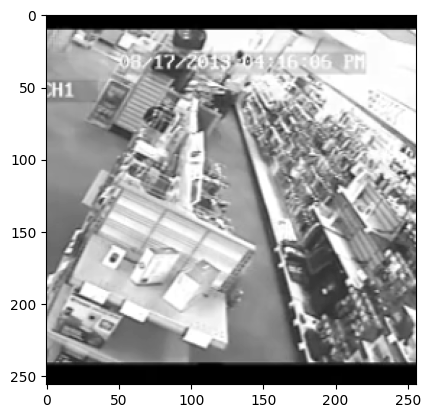

In [5]:
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

start_sec = 0
end_sec = start_sec + clip_duration

# !ls

video = EncodedVideo.from_path("./DCSASS/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_19.mp4")
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data = transform(video_data)
inputs = video_data["video"]

device = "cpu"

# Check a frame ...
print(inputs[0].shape)
print(inputs[1].shape)
plt.imshow(inputs[0][0][0].to("cpu"), cmap="gray")
plt.plot()

inputs = [i.to(device)[None, ...] for i in inputs]
crime_detector = crime_detector.to(device)

# Slowfast forward propagation
outputs = crime_detector(inputs)

print(outputs.item())

## Test inference of classifier

Using snippets from "live demo"

In [ ]:
import cv2
import os
import torch
from torchvision.transforms import Compose  # Ensure your transform is defined

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

#####################################################################
# REMINDER :
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
frame_delay = int(1000 / 60)  # Delay per frame in milliseconds
slowfast_alpha = 4
num_clips = 10
num_crops = 3
clip_duration = (num_frames * sampling_rate) / frames_per_second
#####################################################################

dcsass_path = "./DCSASS/Shoplifting"

# Resize scale factor
scale_factor = 2.0  # Change this to control the scaling (e.g., 1.5, 2.0, etc.)

# Iterate through directories and files
for folder in os.listdir(dcsass_path):
    folder_path = os.path.join(dcsass_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            video_path = os.path.join(folder_path, file)

            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                raise Exception(f"Error: Could not open video file {video_path}")

            # Compute video score only once for the video snippet
            video = EncodedVideo.from_path(video_path)
            video_data = video.get_clip(start_sec=0, end_sec=clip_duration)
            video_data = transform(video_data)
            inputs = video_data["video"]

            inputs = [i.to(device)[None, ...] for i in inputs]
            crime_detector = crime_detector.to(device)
            with torch.no_grad():
                preds = crime_detector(inputs)
            raw_score = float(preds[0].item())
            score = 100*torch.sigmoid(torch.tensor(3*(raw_score+1))).item()
            print(f"Prediction score for {file}: {score:.2f}%")

            # Display the video with text overlay
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Resize frame for display
                original_height, original_width = frame.shape[:2]
                new_width = int(original_width * scale_factor)
                new_height = int(original_height * scale_factor)
                frame = cv2.resize(frame, (new_width, new_height))

                # Display prediction on the frame
                text = f"Crime Score: {score:.2f} %"
                color = (0, 0, 255) if score > 50 else (0, 255, 0)
                cv2.putText(frame, text, (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

                # Show the frame
                cv2.imshow('Crime Detection', frame)

                # Break loop on 'q' press
                if cv2.waitKey(frame_delay) & 0xFF == ord('q'):
                    break

            cap.release()

# Close all windows at the end
cv2.destroyAllWindows()


cuda
Prediction score for Shoplifting001_x264_0.mp4: 16.42%
Prediction score for Shoplifting001_x264_1.mp4: 46.18%
Prediction score for Shoplifting001_x264_10.mp4: 63.32%
Prediction score for Shoplifting001_x264_11.mp4: 66.45%
Prediction score for Shoplifting001_x264_12.mp4: 63.69%
Prediction score for Shoplifting001_x264_13.mp4: 0.17%
Prediction score for Shoplifting001_x264_14.mp4: 98.70%
Prediction score for Shoplifting001_x264_15.mp4: 72.47%
Prediction score for Shoplifting001_x264_16.mp4: 38.31%
Prediction score for Shoplifting001_x264_17.mp4: 1.46%
Prediction score for Shoplifting001_x264_18.mp4: 0.00%
Prediction score for Shoplifting001_x264_19.mp4: 6.02%
Prediction score for Shoplifting001_x264_2.mp4: 1.58%
Prediction score for Shoplifting001_x264_20.mp4: 2.85%
Prediction score for Shoplifting001_x264_21.mp4: 0.10%
Prediction score for Shoplifting001_x264_22.mp4: 0.81%
Prediction score for Shoplifting001_x264_23.mp4: 4.21%
Prediction score for Shoplifting001_x264_24.mp4: 0.09%


KeyboardInterrupt: 